<a href="https://colab.research.google.com/github/zomungGITHUB/MLGeo-2023/blob/main/ASCE_GI_Summer_School_CPT_SBT_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASCE-GI Summer School: Cone Penetration Testing
***Updated June 27 2025***

**CPT-based Soil Behavior Type (SBT) interpretation**
*   This code will process CPT data based on interpretation in ConeTec (2023)
*   The objectives of these scripts are to (i) interpret unit weight, (ii) estimate effective stress profiles including water table depth, and (iii) estimate soil profiles based on SBT interpretation





**How to use these scripts**


*   Read comments and instructions at the top of each cell and in the code
*   Run each kernal individually with the triangle symbol on the left of each kernal
*   Input values where necessary; you will need to re-run dependent kernals when input parameters change.
*   Look at the text and notes for when inputs are needed.




**Objectives**
*   Interpret soil units, based on CPT data, from a liquefaction site in Iskenderun, Turkiye. There was evidence of severe liquefaction at this site from the February 6, 2023 Mw 7.8 earthquake.
*   The CPT name is ISK_CPT_05
*   CPT data are in the file ISK_CPT_05.csv
*   Identify the major soil units present at the site and their depth.
*   Identify the soil units susceptible to liquefaction based on soil behavior type index (Ic) < 2.6 soils being sand-like and likely liquefiable

**Acknowledgments**


*   ISK_CPT_05 data collection supported by the National Science Foundation project CMMI-2338025
*   Other subsurface data available on DesignSafe: [PRJ-5805](https://doi.org/10.17603/ds2-6473-fs88)
*   Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the National Science Foundation.



**Import necessary packages**

In [ ]:
import numpy as np
import pandas as pd
import math
import io
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns  #color dictionaries
from google.colab import files
from plotly.subplots import make_subplots
pd.options.mode.chained_assignment = None  # default='warn'


**Set input data units and other constants**:

User input required to specify the units of the input data, and other unit inputs for analysis

*   units are input as type string
*   unit options recognized by these scripts are listed to the right of each data line
*   The input should be in " "
*   For example, if the units for qc in the input file are psi, then the line should read: qc_input_units = "psi"

In [ ]:
sigma_atm_kpa = 101.3       #[kPa], INPUT
gamma_water = 9.81          #[kN/m^3], INPUT

qc_input_units = "mpa"      #[mpa, kpa, psi, psf, tsf], INPUT
fs_input_units = "kpa"      #[mpa, kpa, psi, psf, tsf], INPUT
u2_input_units = "kpa"      #[mpa, kpa, psi, psf, tsf], INPUT
depth_input_units = "m"     #[m, feet], INPUT

ac = 0.8                    #area ratio for the cone penetration test, INPUT

elev_corr = 0.0             #[m], elevation at the ground surface, INPUT

**Set INPUT file**

Imports the cpt data into a dataframe called "cpt_ws"


*   Need to input the file name, including extension in the uploaded[] input. The file name should be input with ''.
*   For example: uploaded['file_name']
*   When the kernal is running, select the "Choose Files" button and select the input file from the file directory.



In [ ]:
uploaded = files.upload()
cpt_ws = pd.read_csv(io.BytesIO(uploaded['ISK_CPT_05.csv']), names=['depth','qc','fs','u2'], skiprows=[0])
cpt_ws.head(n=1)

Saving ISK_CPT_05.csv to ISK_CPT_05.csv


,depth,qc,fs,u2
0,0.02,0.0,-8888,-8888.0


**Define functions for unit conversion**  
This section defines functions to convert units of the input data to meters and kPa
*   No user input needed

In [ ]:
def feet_to_meters(feet):
    """converts feet to meters"""
    return feet*0.3048
def tsf_to_kpa(tsf):
    """converts tsf to kPa"""
    return tsf*107.25178
def psi_to_kpa(psi):
    """converts psi to kPa"""
    return psi*6.894757
def mpa_to_kpa(mpa):
    """converts MPa to kPa"""
    return mpa*1000
def psf_to_kpa(psf):
    """converts psi to kPa"""
    return psf*20.885434273
### end of unit conversions


**Convert Units**

This kernal converts the raw and input CPT data to standard units.
*   No user inputs needed.

**Hint:** You can see the data frame data (and values of any other variables) by selecting the *{x}* symbol to the left and selecting the variable

In [ ]:
#Initialize the dataframe cpt_interp from the imported spreadsheet
cpt_interp = cpt_ws.copy()

#Get the maximum depth from the "depth" column
depth = cpt_ws['depth']
max_depth = max(depth)

#Convert depth units to meters [m], apply an elevation correction
if (depth_input_units == "m"):
  depth = depth
  elev = elev_corr - depth
elif (depth_input_units == "feet"):
  depth = feet_to_meters(depth)
  depth.columns.values[0] = "Depth_m"
  elev = elev_corr - depth
  elev.columns.values[0] = "Elev_m"
else:
  print("depth units not admissable")

## Add the depth and elevation in [m] data to the cpt_interp dataframe
cpt_interp.rename(columns = {cpt_interp.columns[0]:'depth_raw'}, inplace = True)
cpt_interp=pd.concat([cpt_interp,depth], axis=1)    #concat depth (in meters) onto the cpt_interp dataframe
cpt_interp.rename(columns = {cpt_interp.columns[4]:'Depth_m'}, inplace = True)
cpt_interp = pd.concat([cpt_interp,elev],axis=1)
cpt_interp.rename(columns = {cpt_interp.columns[5]:'Elev_m'}, inplace = True)

#Convert qc data to [kPa]
qc = cpt_ws['qc']
if (qc_input_units == "mpa"):
  qc = mpa_to_kpa(qc)
elif (qc_input_units == "kpa"):
  qc = qc
elif (qc_input_units == "tsf"):
  qc = tsf_to_kpa(qc)
elif (qc_input_units == "psi"):
  qc = psi_to_kpa(qc)
elif (qc_input_units == "psf"):
  qc = psf_to_kpa(qc)
else:
  print("qc units not admissable")

#concat converted qt data to the cpt_interp dataframe
cpt_interp.rename(columns = {cpt_interp.columns[1]:'qc_raw'}, inplace = True)
cpt_interp=pd.concat([cpt_interp,qc], axis=1)
cpt_interp.rename(columns = {cpt_interp.columns[6]:'qc_kpa'}, inplace = True)

#Convert fs data to [kPa]
fs = cpt_ws['fs']
if (fs_input_units == "mpa"):
  fs = mpa_to_kpa(fs)
elif (fs_input_units == "kpa"):
  fs = fs
elif (fs_input_units == "tsf"):
  fs = tsf_to_kpa(fs)
elif (fs_input_units == "psi"):
  fs = psi_to_kpa(fs)
elif (fs_input_units == "psf"):
  fs = psf_to_kpa(fs)
else:
  print("fs units not admissable")

#concat converted fs data to the cpt_interp dataframe
cpt_interp.rename(columns = {cpt_interp.columns[2]:'fs_raw'}, inplace = True)
cpt_interp=pd.concat([cpt_interp,fs], axis=1)
cpt_interp.rename(columns = {cpt_interp.columns[7]:'fs_kpa'}, inplace = True)

#convert u2 data to [kPa]
u2 = cpt_ws['u2']
if (u2_input_units == "mpa"):
  u2 = mpa_to_kpa(u2)
elif (u2_input_units == "kpa"):
  u2 = u2
elif (u2_input_units == "tsf"):
  u2 = tsf_to_kpa(u2)
elif (u2_input_units == "psi"):
  u2 = psi_to_kpa(u2)
elif (u2_input_units == "psf"):
  u2 = psf_to_kpa(u2)
else:
  print("u2 units not admissable")

#concat converted fs data to the cpt_interp dataframe
cpt_interp.rename(columns = {cpt_interp.columns[3]:'u2_raw'}, inplace = True)
cpt_interp=pd.concat([cpt_interp,u2], axis=1)
cpt_interp.rename(columns = {cpt_interp.columns[8]:'u2_kpa'}, inplace = True)



**Plot CPT data, including qc, fs, and u2**

Plots CPT data including u2, and static water pressure

*   INPUT the water table depth based on your interpretation from u2 data
*   If the water table depth is changed, this kernal must be re-run


In [ ]:
##### Input this value
## re-run this kernal and subsequent kernal after the value changes
water_depth = 2.0   #water table depth in [m] below the ground surface
########################################

#Function to calculate static water pressure based on selected water depth
def uo(elev, depth, water_depth):
    water_height = 0. - elev - water_depth
    water_height[water_height < 0] = 0
    return water_height*gamma_water

#add a data column for static water pressure (uo) values
cpt_interp['uo_kpa']=uo(cpt_interp['Elev_m'], cpt_interp['Depth_m'], water_depth)

# Generate three subplots for qc, fs, and u2; CPT data will be plotted below
# subplots are called "fig_cpt"
fig_cpt = make_subplots(rows = 1, cols = 3)

#plot qc profile
fig_cpt.add_scatter(x=cpt_interp['qc_kpa'], y=cpt_interp['Elev_m'],
                mode = 'lines', line = {'color':'grey', 'width':1.5},
                row = 1, col = 1)
fig_cpt.update_xaxes(title="qc (kPa)", range = [0,12500], showgrid=True,gridwidth=1,gridcolor='Grey', row=1, col =1)
fig_cpt.update_yaxes(title="Elevation (m)", showgrid=True, gridwidth=1, gridcolor='Grey', row=1, col = 1)

#plot fs profile
fig_cpt.add_scatter(x=cpt_interp['fs_kpa'], y=cpt_interp['Elev_m'],
                mode = 'lines', line = {'color':'grey', 'width':1.5},
                row = 1, col = 2)
fig_cpt.update_xaxes(title="fs (kPa)", range = [0,150], showgrid=True,gridwidth=1,gridcolor='Grey', row=1, col =2 )
fig_cpt.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Grey', row=1, col = 2)

#plot u2 profile
fig_cpt.add_scatter(x=cpt_interp['u2_kpa'], y = cpt_interp['Elev_m'],
                mode = 'lines', line = {'color':'grey', 'width':1.5},
                row = 1, col = 3)
fig_cpt.update_xaxes(title="u2 (kPa)",range=[-20,1000], showgrid=True,gridwidth=1,gridcolor='Grey', row=1, col =3 )
fig_cpt.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Grey', row=1, col = 3)

#Plot uo profile based on water_depth specified above
fig_cpt.add_scatter(x=cpt_interp['uo_kpa'], y=cpt_interp['Elev_m'],
                    name = 'static water', line = {'color':'blue', 'width':1.5},
                    row=1, col=3)

#Update figure layout properties
fig_cpt.update_layout(autosize = False, width = 900, height = 600)
fig_cpt.update_yaxes(range = [-33,0])
fig_cpt.update_layout(showlegend=False)
fig_cpt.show()

**CPT data variables**

*   This section calculates standard CPT data variables and stores them in the CPT_interp dataframe
*   Additional parameters (including Bq) that require stress profiles are calculated below
*   No user input needed


In [ ]:
# [kPa] area-corrected cone tip resistance (qt)
cpt_interp['qt_kpa'] = cpt_interp['qc_kpa']+cpt_interp['u2_kpa']*(1-ac) # ac variable is input above

# [kPa] effective cone resistance (qE)
cpt_interp['qE_kpa'] = cpt_interp['qt_kpa'] - cpt_interp['u2_kpa']

# [-] normalized cone tip resistance (qcN)
cpt_interp['qcN'] = cpt_interp['qt_kpa']/sigma_atm_kpa    #atmostpheric pressure is input above

# [%] friction ratio (Rf)
cpt_interp['Rf'] = 100.0*cpt_interp['fs_kpa']/cpt_interp['qt_kpa']



**CPT-based measurements unit weight interpretation functions**

*   These are set up as functions for different methods of interpreting unit weight
*   No user input needed

In [ ]:
# Robertson & Cabal (2010)
def uw_robertson_cabal(fs,qt):
    fs[fs<0.001] = 0.001
    qt[qt<0.001] = 0.001
    gamma_robertson = gamma_water*(1.776+0.27*np.log10(fs/sigma_atm_kpa)+0.09*np.log10(qt/sigma_atm_kpa))
    return gamma_robertson

# Mayne (2014)
def uw_mayne_2014(fs):
    fs[fs<0.001] = 0.001
    return gamma_water*(1.22+0.345*np.log10(100*(fs/sigma_atm_kpa)+0.01))

# Conetec manual (2023)
def uw_conetec(qE):
    qE[qE<0.001] = 0.001
    return gamma_water*(1.54+0.254*np.log10(qE/sigma_atm_kpa))

# recommended in the 2023 Conetec manual
def uw_conetec_rec(gam_1, gam_2, gam_3):
    return (1/3)*(gam_1 + gam_2 + gam_3)


**Interpret Unit Weight Profiles**

*   These lines of code call the unit weight functions above
*   No user input needed


In [ ]:
###Run Unit weight functions####

#call the unit weight functions
cpt_interp['gamma_robertson_cabal'] = uw_robertson_cabal(cpt_interp['fs_kpa'], cpt_interp['qt_kpa'])
cpt_interp['gamma_mayne'] = uw_mayne_2014(cpt_interp['fs_kpa'])
cpt_interp['gamma_conetec'] = uw_conetec(cpt_interp['qE_kpa'])
cpt_interp['gamma_conetec_rec'] = uw_conetec_rec(cpt_interp['gamma_robertson_cabal'], cpt_interp['gamma_mayne'], cpt_interp['gamma_conetec'])

/tmp/ipython-input-9-1085946889.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



**Input and Plot Unit Weights**

There is an **input** section that you should fill out
- Examine the interpreted unit weight profiles
- Use your judgement to estimate where there are changes in unit weight
- **INPUT** your estimates of the top and bottom of the unit weight sections
- **INPUT** your estimates of the unit weight for each unit
- Plot the updated estimates, evaluate how well they match the profiles
- ***Update and iterate*** your inputs until you judge the unit weights to be appropriately estimated


In [ ]:

#input unit weights and bottoms of layers
#plot and iterate
#You can add more units as needed; if you need more, then you need to add variables for unit_i_gamma; unit_i_top; unit_i_bot and add to unit_gamma, unit_top, unit_bot; update number_gamma_units
unit_1_gamma = 18.2 #[kN/m^3]
unit_2_gamma = 17.1 #[kN/m^3]
unit_3_gamma = 16.4 #[kN/m^3]
unit_4_gamma = 17.3 #[kN/m^3]
unit_5_gamma = 16.8 #[kN/m^3]
unit_1_top = -3    #[m]
unit_1_bot = -10.0  #[m]
unit_2_bot = -19.0  #[m]
unit_3_bot = -21.5  #[m]
unit_4_bot = -23.0  #[m]
unit_5_bot = -30.0  #[m]

number_gamma_units = 5 #number of units
# end of inputs

#set the top of each unit equal to the bottom of the above unit
unit_2_top = unit_1_bot
unit_3_top = unit_2_bot
unit_4_top = unit_3_bot
unit_5_top = unit_4_bot

# put unit weight units into lists for plotting and looping
unit_gamma = [unit_1_gamma, unit_2_gamma, unit_3_gamma, unit_4_gamma, unit_5_gamma]
unit_top = [unit_1_top, unit_2_top, unit_3_top, unit_4_top, unit_5_top]
unit_bot = [unit_1_bot, unit_2_bot, unit_3_bot, unit_4_bot, unit_5_bot]

#plot interpreted unit weights in a figure called "fig_uw"
fig_uw = px.line(width = 400*1.5, height = 400*1.5)

fig_uw.add_scatter(x=cpt_interp['gamma_conetec_rec'], y=cpt_interp['Elev_m'],
                   mode = 'lines', line={'color':'black', 'width':2.0},
                   name = "Conetec (2023) Recommended")

fig_uw.add_scatter(x=cpt_interp['gamma_robertson_cabal'], y=cpt_interp['Elev_m'],
                   mode = 'lines', line={'color':'magenta', 'width':1.0},
                   name="Robertson & Cabal(2010)")
fig_uw.add_scatter(x=cpt_interp['gamma_mayne'], y=cpt_interp['Elev_m'],
                   mode = 'lines', line={'color':'gray', 'width':1.0},
                   name="Mayne (2014)")
fig_uw.add_scatter(x=cpt_interp['gamma_conetec'], y=cpt_interp['Elev_m'],
                   mode = 'lines', line={'color':'green', 'width':1.0},
                   name="Conetec (2023)")

# plot the interpreted unit weight units and values
for i in range(number_gamma_units):
    fig_uw.add_scatter(x=[unit_gamma[i],unit_gamma[i]], y=[unit_top[i],unit_bot[i]],
                    mode='lines', line={'color':'blue', 'width':2.0},
                    name = 'Unit '+str(i+1)+' ' +'gamma = ' + str(unit_gamma[i]) + ' kN/m^3')

#update formatting on the plot
fig_uw.update_layout(legend_title_text = "unit weight", showlegend=True)
fig_uw.update_yaxes(range = [-30,0], title = "Elevation (m)")
fig_uw.update_xaxes(title="Unit Weight (kN/m^3)", range=[12,20])
fig_uw.show()

**Total and Vertical Effective Stress Profiles**


Calculates and plots total vertical stress, static porewater pressure, and vertical effective stress profiles based on unit weight inputs
*   No user inputs needed unless you added unit weight units in the kernal above



In [ ]:
#function to calculate total vertical stress
def sigma_v(depth_m, elev_m, unit_gamma, unit_top, unit_bot):
    length = len(depth_m)
    sigma_v_kpa = [0.0]*length
    for x in range(length):
        if x == 0:
            sigma_v_kpa[x] = depth_m[x]*unit_1_gamma
        elif elev_m[x] < unit_2_top:
            xm1 = x-1
            sigma_v_kpa[x] = sigma_v_kpa[xm1] + unit_1_gamma*(depth_m[x]-depth_m[xm1])
        elif elev_m[x] < unit_3_top:
            xm1 = x-1
            sigma_v_kpa[x] = sigma_v_kpa[xm1] + unit_2_gamma*(depth_m[x]-depth_m[xm1])
        elif elev_m[x] < unit_4_top:
            xm1 = x-1
            sigma_v_kpa[x] = sigma_v_kpa[xm1] + unit_3_gamma*(depth_m[x]-depth_m[xm1])
        elif elev_m[x] <= max(elev_m):
            xm1 = x-1
            sigma_v_kpa[x] = sigma_v_kpa[xm1] + unit_4_gamma*(depth_m[x]-depth_m[xm1])
    return(sigma_v_kpa)

#call function to calculate total vertical stress
cpt_interp['sigma_v_kpa'] = sigma_v(cpt_interp['Depth_m'], cpt_interp['Elev_m'], unit_gamma, unit_top, unit_bot)
#calcultate vertical effective stress
cpt_interp['sigma_v_prime_kpa'] = cpt_interp['sigma_v_kpa'] - cpt_interp['uo_kpa']
# [-] pore pressure parameter that requires stress profile
cpt_interp['Bq'] = (cpt_interp['u2_kpa'] - cpt_interp['uo_kpa'])/(cpt_interp['qt_kpa']-cpt_interp['sigma_v_kpa'])
# [kPa] stress normalized cone tip resistance (Lunnet et al. 1997)
cpt_interp['Qt'] = (cpt_interp['qt_kpa'] - cpt_interp['sigma_v_kpa'])/cpt_interp['sigma_v_prime_kpa']

#plot stress profiles
fig_sigma = px.line()

fig_sigma.add_scatter(x=cpt_interp['sigma_v_prime_kpa'], y=cpt_interp['Elev_m'],
                      line={'color':'grey', 'width':1.5},
                      name='vertical effective stress')

fig_sigma.add_scatter(x=cpt_interp['sigma_v_kpa'], y=cpt_interp['Elev_m'],
                      mode = 'lines', line = {'color':'red', 'width':1.5},
                      name='total vertical stress'
                      )
fig_sigma.add_scatter(x=cpt_interp['uo_kpa'], y=cpt_interp['Elev_m'],
                      mode='lines', line = {'color':'blue', 'width':1.5},
                      name = 'static porewater pressure'
                      )
fig_sigma.update_layout(autosize = False, width = 600, height = 600)
fig_sigma.update_yaxes(title="Elevation (m)")
fig_sigma.update_xaxes(title="Stress (kPa)")
fig_sigma.update_layout(showlegend=True)

fig_sigma.show()


**CPT-based Soil Behavior Type (SBT) variables**

Calculate soil behavior type variables





*   No user input needed






In [ ]:
### CPT-based soil behavior type (SBT) interpretation
# Ic Robertson 2009
def Ic_Robertson_2009(sigma_v, uo, sigma_v_prime, qt, fs):
    n = 1.0  #start with n = 1.0, will iterate
    Qtn = ((qt - sigma_v)/sigma_atm_kpa)/((sigma_v_prime/sigma_atm_kpa)**n)
    for x in Qtn:           #loop to make sure all entries are non-zero and positive
        if x < 0.001:
            x = 0.001
    Fr = 100*fs/(qt-sigma_v)
    Fr[Fr<0.001] = 0.001
    Fr = Fr.astype(float) #convert entries to type float for log10 operation
    Fr_log = np.log10(Fr)
    for x in range(20):
        Qtn = Qtn.astype(float) #convert entries to type float for log10 operation
        Qtn[Qtn<0.001] = 0.001
        Qtn_log = np.log10(Qtn)
        Ic = ((3.47-Qtn_log)**2+(1.22+Fr_log)**2)**0.5
        n = 0.381*Ic+0.05*(sigma_v_prime/sigma_atm_kpa)-0.15
        n[n>1.0] = 1.0      #n values are less than or equal to 1.0
        Qtn_2 = ((qt - sigma_v)/sigma_atm_kpa)/(sigma_v_prime/sigma_atm_kpa)**n
        Qtn = Qtn_2
    return Ic, Qtn, Fr
#### End of Ic Robertson 2009 calculation

###Ic SBT zones, for Plotting
Ic_7 = [1.31, 1.31]
Ic_6 = [2.05, 2.05]
Ic_5 = [2.60, 2.60]
Ic_4 = [2.95, 2.95]
Ic_3 = [3.60, 3.60]

elev_min = min(cpt_interp['Elev_m'])
y_depth = [0,elev_min]
### end of Ic SBT zones

## IB Robertson 2016"""
def IB_Robertson_2016(Qtn,Fr):
    Qtn[Qtn<0.001] = 0.001
    Fr[Fr<0.001] = 0.001
    IB = 100*(Qtn+10)/(Qtn*Fr+70)
    CD = (Qtn-11)*(1+0.06*Fr)**17
    return IB, CD

IB_CD = [70,70]
## End of IB
### end of CPT-based SBT index functions


## Call functions to interpret SBT
cpt_interp['Ic_Robertson_2009'], cpt_interp['Qtn'], cpt_interp['Fr']  = Ic_Robertson_2009(cpt_interp['sigma_v_kpa'], cpt_interp['uo_kpa'],
                                                                      cpt_interp['sigma_v_prime_kpa'], cpt_interp['qt_kpa'], cpt_interp['fs_kpa'])
cpt_interp['IB_Robertson_2016'], cpt_interp['CD_Robertson_2016'] = IB_Robertson_2016(cpt_interp['Qtn'], cpt_interp['Fr'])



**Plot CPT-based Soil Behavior Type (SBT) variables**

Plot soil behavior type variables

*   No user input needed



In [ ]:
## Plot SBT interpretations
fig_SBT = make_subplots(rows = 1, cols = 3)

#Plot Robertson (2009) Ic SBT interpreted from CPT data
fig_SBT.add_scatter(x=cpt_interp['Ic_Robertson_2009'], y=cpt_interp['Elev_m'],
                    mode = 'lines', line = {'color':'blue', 'width':1.5}, row=1, col=1)
fig_SBT.update_xaxes(title = "Ic Robertson (2009)", range=[1,4], row=1, col=1)
#Plot standard Ic values
fig_SBT.add_scatter(x=Ic_4, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT.add_scatter(x=Ic_5, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT.add_scatter(x=Ic_6, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT.add_scatter(x=Ic_7, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)

#Plot Robertson (2016) IB behavior type index interpreted from CPT data
fig_SBT.add_scatter(x=cpt_interp['IB_Robertson_2016'], y=cpt_interp['Elev_m'],
                    mode='lines',line={'color':'blue', 'width':1.5}, row=1, col=2)
fig_SBT.update_xaxes(title = "IB Robertson (2016)", range=[0,150], row=1, col=2)


#Plot Robertson (2016) Contractive Dilative (CD) interpreted from CPT data
fig_SBT.add_scatter(x=cpt_interp['CD_Robertson_2016'], y=cpt_interp['Elev_m'],
                    mode='lines', line = {'color':'blue', 'width':1.5}, row=1, col=3)
fig_SBT.add_scatter(x=IB_CD, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=3)
fig_SBT.update_xaxes(title = "CD Robertson (2016)", range=[-80,250], row=1, col=3)
fig_SBT.add_annotation(x=150, y=-2, text="dilative", showarrow=False, row=1, col=3)
fig_SBT.add_annotation(x=0, y=-2, text="contractive", showarrow=False, row=1, col=3)


fig_SBT.update_yaxes(title = "Elevation (m)", range = [-30,0], row=1, col=1)
fig_SBT.update_yaxes(range = [-30,0], row=1, col=2)
fig_SBT.update_layout(height = 500, width = 800)
fig_SBT.update_layout(showlegend=False)
fig_SBT.show()


**Soil Behavior Type Plots**

Plot SBT plots Qtn vs. Fr; Qt vs. Bq; Qt vs delta_u

*   No user input required

In [ ]:
fig_SBT_2 = make_subplots(rows = 1, cols =3)

#Plot Robertson (2009) Ic SBT interpretation on Qtn - Fr plot
fig_SBT_2.add_scatter(x=cpt_interp['Fr'], y=cpt_interp['Qtn'],
                    mode = 'markers', row=1, col=1)
fig_SBT_2.update_xaxes(type="log", title = "Fr",range = [-1,1], row=1, col=1) # log range: 10^-1 = 0.1; 10^1 = 10
fig_SBT_2.update_yaxes(type="log", title = "Qtn", range = [0,3], row=1, col=1) # log range: 10^0 = 1; 10^3 = 1000

#Plot SBT zones from Robertson (1990)
SBT_zone_1_x = [0.1, 0.1103, 0.1228, 0.1403, 0.1693, 0.1953, 0.2377, 0.2741, 0.3162, 0.3747, 0.4479, 0.5402, 0.6231, 0.7317, 0.829, 1.0, 1.123, 1.2169, 1.3305, 1.4678, 1.5485, 1.5764]
SBT_zone_1_y = [10., 10.0022, 9.8991, 9.6745, 9.3945, 9.0071, 8.5455, 8.1931, 7.6903, 7.0672, 6.3583, 5.6006, 4.9326, 4.2532, 3.6671, 2.8439, 2.3751, 2.0476, 1.6920, 1.3259, 1.1072, 0.9544]
SBT_zone_2_x = [1.5624, 1.7546, 2.024, 2.2528, 2.5754, 2.9974, 3.4885, 4.439, 5.3064, 6.1759, 7.0605, 8.0002, 8.9844, 10]
SBT_zone_2_y = [1.1072, 1.1555, 1.245, 1.3272, 1.4300, 1.5738, 1.7881, 2.2357, 2.7362, 3.3133 , 3.9694, 4.8062, 5.8193, 6.8250 ]
SBT_zone_3_x = [0.6998, 0.8072, 0.9736, 1.1638, 1.3789, 1.5076, 2.1544, 2.4851, 2.9974, 3.5197, 4.1702, 4.7252, 5.4505, 5.8018]
SBT_zone_3_y = [4.5323, 4.9355, 5.5490, 6.1727, 7.0136, 7.6366, 10.8475, 12.4561, 15.9059, 19.8836, 25.6604, 33.46535, 48.53205, 61.30186]
SBT_zone_4_x = [0.2766, 0.3427, 0.4600, 0.595928, 0.75157, 0.9736, 1.5624, 1.9014, 2.2327, 2.5074, 2.8411, 3.1906, 3.6804, 4.0600, 4.3996, 4.6003, 4.6416, 4.6832]
SBT_zone_4_y = [8.1933, 9.0188, 10.2504,  11.7736, 13.6667, 16.3667, 25.3322, 29.7162, 35.2279, 41.7576, 51.0997, 65.2417, 100.8342, 152.5562, 248.5946, 405.0587, 659.9461, 1019.665 ]
SBT_zone_5_x = [0.1009, 0.13305, .172359, 0.2135, 0.2791, 0.3780, 0.4725, 0.5649, 1.018, 1.2954, 1.6631, 1.9705, 2.3346]
SBT_zone_5_y = [27.4029, 27.4204, 28.3242, 29.5669, 31.8663, 35.8365, 39.8687, 44.35, 67.8915, 85.7904, 119.274, 164.0456, 223.2414]
SBT_zone_6_x = [0.1, .1228, 0.1576, 0.1988, 0.2377, 0.5030, 0.5906, 0.6998, 0.7929, 0.8984, 0.9823]
SBT_zone_6_y = [159.5016, 164.7386, 173.8147, 191.3347, 208.3717, 351.0713, 416.1872, 509.3497, 636.6713, 804.3087, 1026.84]
SBT_zone_89_x = [1.3425, 1.4418, 1.6048, 1.8184, 2.1163, 2.3767, 2.7415, 3.1342, 3.8141, 4.6416, 5.9063, 7.3827, 9.8231]
SBT_zone_89_y = [1006.002, 805.19, 579.62, 426.22, 303.51, 220.89, 164.17, 130.03, 96.65, 74.96, 61.30, 55.75, 54.61]

fig_SBT_2.add_scatter(x=SBT_zone_1_x, y=SBT_zone_1_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_2_x, y=SBT_zone_2_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_3_x, y=SBT_zone_3_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_4_x, y=SBT_zone_4_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_5_x, y=SBT_zone_5_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_6_x, y=SBT_zone_6_y, mode = 'lines', line={'color':'black'}, row=1, col=1)
fig_SBT_2.add_scatter(x=SBT_zone_89_x, y=SBT_zone_89_y, mode = 'lines', line={'color':'black'}, row=1, col=1)

fig_SBT_2.add_annotation(x=-0.5, y=0.5, text="1", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0.8, y=0.2, text="2", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0.6, y=0.8, text="3", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0.25, y=1.2, text="4", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0, y=1.5, text="5", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=-0.4, y=2, text="6", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=-0.8, y=2.7, text="7", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0.5, y=2.7, text="8", showarrow=False, row=1, col=1)
fig_SBT_2.add_annotation(x=0.8, y=2.2, text="9", showarrow=False, row=1, col=1)
fig_SBT_2.update_annotations(font_size=20, font_weight="bold", )

#Plot Robertson (1990) SBT with Bq
fig_SBT_2.add_scatter(x=cpt_interp['Bq'], y=cpt_interp['Qt'],
                    mode = 'markers', row=1, col=2)
fig_SBT_2.update_xaxes(title = "Bq", range = [-0.6,1.5], row=1, col=2)
fig_SBT_2.update_yaxes(type="log", title = "Qt", range=[0,3], row=1, col=2)

#add Robertson (1990) SBT zones with Bq
SBT_Bq_zone_1_x = [-0.04669, -0.55734, 0.14429, 0.53218, 0.80317, 1.39095, 0.17717, 0.083817]
SBT_Bq_zone_1_y = [995.1239, 19.27011, 1.00397, 2.581247, 1.01943, 10.50417, 103.22677, 993.98497]
SBT_Bq_zone_0_x = [0, 0]
SBT_Bq_zone_0_y = [1,1000]
SBT_Bq_zone_2_x = [-0.3987, 0.0, 0.584956]
SBT_Bq_zone_2_y = [63.2482, 5.087911, 47.18714]
SBT_Bq_zone_3_x = [-0.31945, 0.0, 0.40655]
SBT_Bq_zone_3_y = [118.8875, 11.68986, 66.19802]
SBT_Bq_zone_4_x = [-0.2560, 0, 0.2154]
SBT_Bq_zone_4_y = [196.973, 30.8003, 94.8552]
SBT_Bq_zone_5_x = [-0.1609, 0, 0.12893]
SBT_Bq_zone_5_y = [411.307, 178.753, 299.134]

fig_SBT_2.add_scatter(x=SBT_Bq_zone_1_x, y=SBT_Bq_zone_1_y, mode = 'lines', line={'color':'black'}, row=1, col=2)
fig_SBT_2.add_scatter(x=SBT_Bq_zone_0_x, y=SBT_Bq_zone_0_y, mode = 'lines', line={'color':'black'}, row=1, col=2)
fig_SBT_2.add_scatter(x=SBT_Bq_zone_2_x, y=SBT_Bq_zone_2_y, mode = 'lines', line={'color':'black'}, row=1, col=2)
fig_SBT_2.add_scatter(x=SBT_Bq_zone_3_x, y=SBT_Bq_zone_3_y, mode = 'lines', line={'color':'black'}, row=1, col=2)
fig_SBT_2.add_scatter(x=SBT_Bq_zone_4_x, y=SBT_Bq_zone_4_y, mode = 'lines', line={'color':'black'}, row=1, col=2)
fig_SBT_2.add_scatter(x=SBT_Bq_zone_5_x, y=SBT_Bq_zone_5_y, mode = 'lines', line={'color':'black'}, row=1, col=2)

fig_SBT_2.add_annotation(x=1.2, y=0.25, text="1", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.5, y=0.2, text="2", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.5, y=0.8, text="3", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.3, y=1.4, text="4", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.18, y=1.65, text="5", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.1, y=2, text="6", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.05, y=2.7, text="7", showarrow=False, row=1, col=2)
fig_SBT_2.update_annotations(font_size=20, font_weight="bold", )
fig_SBT_2.add_annotation(x=0.55, y=1.15, text="Increasing OCR", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=0.2, y=1.2, text="", showarrow=True, ax=40, ay=30, arrowhead = 3, arrowwidth=2.5, row=1, col=2)
fig_SBT_2.add_annotation(x=0.7, y=0.55, text="Increasing sensitivity", showarrow=False, row=1, col=2)
fig_SBT_2.add_annotation(x=1.1, y=0.15, text="", showarrow=True, ax=-40, ay=-30, arrowhead = 3, arrowwidth=2.5, row=1, col=2)


#Plot Schneider (2008) SBT with pore pressure parameter
cpt_interp['schneider_SBT_del_u'] = (cpt_interp['u2_kpa']-cpt_interp['uo_kpa'])/cpt_interp['sigma_v_prime_kpa']
fig_SBT_2.add_scatter(x=cpt_interp['schneider_SBT_del_u'], y=cpt_interp['Qt'],
                    mode = 'markers', row=1, col=3)
y1=np.logspace(0,3.5,100)
x1=((y1**1.25)/100)+0.99
y2=np.logspace(0.1,2,100)
x2=((y2**0.95)/5)+1.05
y3=np.logspace(0.56,1.5,100)
x3=((y3**0.91)/1.5)+1.5
y4=np.logspace(0,1.1,100)
x4=y4
y5=np.logspace(1.28,3,100)
x5=-0.5*np.log(y5/20)
x5[x5<-1] = -1
y6 = np.logspace(1.28,3,100)
x6=0.5*np.log(y6/20)
x6[x6>1]=1
fig_SBT_2.add_scatter(x=x1, y=y1, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.add_scatter(x=x2, y=y2, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.add_scatter(x=x3, y=y3, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.add_scatter(x=x4, y=y4, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.add_scatter(x=x5, y=y5, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.add_scatter(x=x6, y=y6, mode='lines', line={'color':'black'}, row=1, col=3)
fig_SBT_2.update_xaxes(title = "u2-uo/sig_vo'", range=[-4,12], dtick=2, row=1, col=3)
fig_SBT_2.add_annotation(x=9, y=2.8, text="Transitional Soils", showarrow=False, row=1, col=3)
fig_SBT_2.add_annotation(x=9, y=2, text="Silts & Low Ir Clays", showarrow=False, row=1, col=3)
fig_SBT_2.add_annotation(x=10, y=1.5, text="Clays", showarrow=False, row=1, col=3)
fig_SBT_2.add_annotation(x=9.8, y=1.1, text="Sensitive Clays", showarrow=False, textangle=-15, row=1, col=3)
fig_SBT_2.add_annotation(x=0, y=2.3, text = "Essentially drained",showarrow=False,textangle=-90,row=1,col=3)
fig_SBT_2.add_annotation(x=5.5, y=0.98, text = "Increasing OCR", showarrow=False, textangle=-35, row=1, col=3)
fig_SBT_2.add_annotation(x=5, y=1.1, text = "", showarrow=True, ax=-50, ay=50, arrowhead = 3, arrowwidth=1.5, row=1, col=3)
fig_SBT_2.add_annotation(x=-1, y=1.1, text = "Increasing Cv", showarrow=False, row=1, col=3)
fig_SBT_2.add_annotation(x=0.8, y=1.2, text = "", showarrow=True, ax=45, ay=50, arrowhead = 3, arrowwidth=1.5, row=1, col=3)




fig_SBT_2.update_yaxes(type="log", title = "Qt", range=[0,3], row=1, col=3)
fig_SBT_2.update_layout(height = 500, width = 1600, showlegend=False)


**INPUT Interpret Soil Units from SBT plots and profiles**

Use the above Ic, IB, CD vs. depth profiles and SBT charts to:


*   Interpret soil units; input the unit bounds in the code below
*   Run the plots scripts below; these will plot the units you specific with different colors
*   Evaluate the consistency of these units with other CPT data and SBT zones
*   Iterate on unit boundaries, plot, evaluate, repeat until you are happy with the results



In [ ]:
# INPUT the top of unit 1 and bottom of the other units you identify
SBT_unit_1_top = -0.0    #[m]
SBT_unit_1_bot = -9.5    #[m]
SBT_unit_2_top = SBT_unit_1_bot
SBT_unit_2_bot = -15.0    #[m]
SBT_unit_3_top = SBT_unit_2_bot
SBT_unit_3_bot = -18.0   #[m]
SBT_unit_4_top = SBT_unit_3_bot
SBT_unit_4_bot = -28.0    #[m]

#INPUT If you add units above, then you need to expand these lists too
SBT_unit_top = [SBT_unit_1_top, SBT_unit_2_top, SBT_unit_3_top, SBT_unit_4_top]
SBT_unit_bot = [SBT_unit_1_bot, SBT_unit_2_bot, SBT_unit_3_bot, SBT_unit_4_bot]

num_SBT_units = len(SBT_unit_top)

def loc_index(depth_seek, depth):
  depth_sort = depth.iloc[(depth-depth_seek).abs().argsort()[:1]]  ## takes the entry of the dataframe closest to the top of the interval
  index = depth_sort.index.tolist()  ## stores the index of the depth closest to the top of the interval
  index = int("".join(map(str,index))) #convert to an integer
  return index

SBT_unit_top_index = {}
SBT_unit_bot_index = {}
for i in range(num_SBT_units):
  SBT_unit_top_index[i] = loc_index(SBT_unit_top[i], cpt_interp['Elev_m'])
  SBT_unit_bot_index[i] = loc_index(SBT_unit_bot[i], cpt_interp['Elev_m'])



**Plot SBT units**

Uses the input soil units above to plot the data with different colors


*   Needs to be re-run anytime the soil units above are updated
*   No user input required



In [ ]:
## Plot SBT interpretations with units
fig_SBT_units = make_subplots(rows = 2, cols = 3)
color = sns.color_palette("husl", num_SBT_units)



#Plot Robertson (2009) Ic SBT interpretation
#cycle through the number of units set above
for i in range(num_SBT_units):
  #get the top and bottom indices
  top_index = SBT_unit_top_index[i]
  bot_index = SBT_unit_bot_index[i]

  #set the color for the unit
  plot_color = color[i]
  rgb1=plot_color[0]
  rgb2=plot_color[1]
  rgb3=plot_color[2]
  plot_color = str("rgb("+str(rgb1)+','+str(rgb2)+','+str(rgb3)+")")

  #plot units Ic vs depth chart
  x_plot=cpt_interp['Ic_Robertson_2009'].iloc[top_index:bot_index]
  y_plot=cpt_interp['Elev_m'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                            mode = 'lines',
                            line =dict(color=plot_color),
                            row=1, col=1)

  #plot units on IB vs depth chart
  x_plot=cpt_interp['IB_Robertson_2016'].iloc[top_index:bot_index]
  y_plot=cpt_interp['Elev_m'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                            mode = 'lines',
                            line =dict(color=plot_color),
                            row=1, col=2)

  #plot units on CD vs depth chart
  x_plot=cpt_interp['CD_Robertson_2016'].iloc[top_index:bot_index]
  y_plot=cpt_interp['Elev_m'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                            mode = 'lines',
                            line =dict(color=plot_color),
                            row=1, col=3)

  #plot units on Qtn vs Fr SBT chart
  x_plot=cpt_interp['Fr'].iloc[top_index:bot_index]
  y_plot=cpt_interp['Qtn'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                    mode = 'markers',
                    marker=dict(color=plot_color),
                    row=2, col=1)

  #plot units on Qtn vs. Bq SBT chart
  x_plot=cpt_interp['Bq'].iloc[top_index:bot_index]
  y_plot=cpt_interp['Qt'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                    mode = 'markers',
                    marker=dict(color=plot_color),
                    row=2, col=2)

  #plot units on Qt vs delta_u/sig_v' SBT chart
  x_plot = cpt_interp['schneider_SBT_del_u'].iloc[top_index:bot_index]
  y_plot = cpt_interp['Qt'].iloc[top_index:bot_index]
  fig_SBT_units.add_scatter(x=x_plot, y=y_plot,
                    mode = 'markers',
                    marker=dict(color=plot_color),
                    row=2, col=3)



#Add Ic values according to SBT zones on Ic vs. Depth chart
fig_SBT_units.update_xaxes(title = "Ic Robertson (2009)", range=[1,4], row=1, col=1)
fig_SBT_units.add_scatter(x=Ic_4, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT_units.add_scatter(x=Ic_5, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT_units.add_scatter(x=Ic_6, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)
fig_SBT_units.add_scatter(x=Ic_7, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=1)

#Format x-axes for Robertson (2016) IB behavior type index on IB vs. Depth chart
fig_SBT_units.update_xaxes(title = "IB Robertson (2016)", range=[0,150], row=1, col=2)

#Plot Robertson (2016) Contractive Dilative (CD) interpretation
fig_SBT_units.add_scatter(x=IB_CD, y=y_depth, mode='lines', line={'dash':'longdash','color':'grey'}, row=1, col=3)
fig_SBT_units.update_xaxes(title = "CD Robertson (2016)", range=[-80,250], row=1, col=3)
fig_SBT_units.add_annotation(x=150, y=-2, text="dilative", showarrow=False, row=1, col=3)
fig_SBT_units.add_annotation(x=0, y=-2, text="contractive", showarrow=False, row=1, col=3)

#for y-axes for depth plots
fig_SBT_units.update_yaxes(title = "Elevation (m)", range = [-30,0], row=1, col=1)
fig_SBT_units.update_yaxes(range = [-30,0], row=1, col=2)
fig_SBT_units.update_yaxes(range = [-30,0], row=1, col=3)
fig_SBT_units.update_layout(showlegend=False)

# format axes in Robertson (1990) Qt vs Fr plot
fig_SBT_units.update_xaxes(type="log", title = "Fr",range = [-1,1], row=2, col=1) # log range: 10^-1 = 0.1; 10^1 = 10
fig_SBT_units.update_yaxes(type="log", title = "Qtn", range = [0,3], row=2, col=1) # log range: 10^0 = 1; 10^3 = 1000
# add zones to Robertson (1990) Qt vs Fr plot
fig_SBT_units.add_scatter(x=SBT_zone_1_x, y=SBT_zone_1_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_2_x, y=SBT_zone_2_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_3_x, y=SBT_zone_3_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_4_x, y=SBT_zone_4_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_5_x, y=SBT_zone_5_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_6_x, y=SBT_zone_6_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
fig_SBT_units.add_scatter(x=SBT_zone_89_x, y=SBT_zone_89_y, mode = 'lines', line={'color':'black'}, row=2, col=1)
# add annotation to Robertson (1990) Qt vs Fr plot
fig_SBT_units.add_annotation(x=-0.5, y=0.5, text="1", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0.8, y=0.2, text="2", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0.6, y=0.8, text="3", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0.25, y=1.2, text="4", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0, y=1.5, text="5", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=-0.4, y=2, text="6", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=-0.8, y=2.7, text="7", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0.5, y=2.7, text="8", showarrow=False, row=2, col=1)
fig_SBT_units.add_annotation(x=0.8, y=2.2, text="9", showarrow=False, row=2, col=1)
fig_SBT_units.update_annotations(font_size=20, font_weight="bold", row=2, col=1)


# format axes in Robertson (1990) Qt vs. Bq plot
fig_SBT_units.update_xaxes(title = "Bq", range = [-0.6,1.5], row=2, col=2)
fig_SBT_units.update_yaxes(type="log", title = "Qt", range=[0,3], row=2, col=2)
#add zones to Robertson (1990) Qt vs. Bq plot
fig_SBT_units.add_scatter(x=SBT_Bq_zone_1_x, y=SBT_Bq_zone_1_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
fig_SBT_units.add_scatter(x=SBT_Bq_zone_0_x, y=SBT_Bq_zone_0_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
fig_SBT_units.add_scatter(x=SBT_Bq_zone_2_x, y=SBT_Bq_zone_2_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
fig_SBT_units.add_scatter(x=SBT_Bq_zone_3_x, y=SBT_Bq_zone_3_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
fig_SBT_units.add_scatter(x=SBT_Bq_zone_4_x, y=SBT_Bq_zone_4_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
fig_SBT_units.add_scatter(x=SBT_Bq_zone_5_x, y=SBT_Bq_zone_5_y, mode = 'lines', line={'color':'black'}, row=2, col=2)
#add annotations to Robertson (1990) Qt vs. Bq plot
fig_SBT_units.add_annotation(x=1.2, y=0.25, text="1", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.5, y=0.2, text="2", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.5, y=0.8, text="3", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.3, y=1.4, text="4", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.18, y=1.65, text="5", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.1, y=2, text="6", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.05, y=2.7, text="7", showarrow=False, row=2, col=2)
fig_SBT_units.update_annotations(font_size=20, font_weight="bold", row=2, col=2 )
fig_SBT_units.add_annotation(x=0.55, y=1.15, text="Increasing OCR", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=0.2, y=1.2, text="", showarrow=True, ax=40, ay=30, arrowhead = 3, arrowwidth=2.5, row=2, col=2)
fig_SBT_units.add_annotation(x=0.7, y=0.55, text="Increasing sensitivity", showarrow=False, row=2, col=2)
fig_SBT_units.add_annotation(x=1.1, y=0.15, text="", showarrow=True, ax=-40, ay=-30, arrowhead = 3, arrowwidth=2.5, row=2, col=2)

#Add zones to the Schnieder (2009) plot
fig_SBT_units.add_scatter(x=x1, y=y1, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.add_scatter(x=x2, y=y2, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.add_scatter(x=x3, y=y3, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.add_scatter(x=x4, y=y4, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.add_scatter(x=x5, y=y5, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.add_scatter(x=x6, y=y6, mode='lines', line={'color':'black'}, row=2, col=3)
fig_SBT_units.update_xaxes(title = "u2-uo/sig_vo'", range=[-4,12], dtick=2, row=2, col=3)
fig_SBT_units.add_annotation(x=9, y=2.8, text="Transitional Soils", showarrow=False, row=2, col=3)
fig_SBT_units.add_annotation(x=9, y=2, text="Silts & Low Ir Clays", showarrow=False, row=2, col=3)
fig_SBT_units.add_annotation(x=10, y=1.5, text="Clays", showarrow=False, row=2, col=3)
fig_SBT_units.add_annotation(x=9.8, y=1.1, text="Sensitive Clays", showarrow=False, textangle=-15, row=2, col=3)
fig_SBT_units.add_annotation(x=0, y=2.3, text = "Essentially drained",showarrow=False,textangle=-90,row=2,col=3)
fig_SBT_units.add_annotation(x=5.5, y=0.98, text = "Increasing OCR", showarrow=False, textangle=-35, row=2, col=3)
fig_SBT_units.add_annotation(x=5, y=1.1, text = "", showarrow=True, ax=-50, ay=50, arrowhead = 3, arrowwidth=1.5, row=2, col=3)
fig_SBT_units.add_annotation(x=-1, y=1.1, text = "Increasing Cv", showarrow=False, row=2, col=3)
fig_SBT_units.add_annotation(x=0.8, y=1.2, text = "", showarrow=True, ax=45, ay=50, arrowhead = 3, arrowwidth=1.5, row=2, col=3)
#make the y-axis of the Schneider (2009) plot log scale
fig_SBT_units.update_yaxes(type="log", title = "Qt", range=[0,3], row=2, col=3)



fig_SBT_units.update_layout(autosize = False, width = 1200, height = 900)
fig_SBT_units.show()


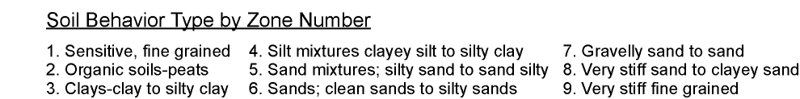